# NiO VASP
*October 1, 2025*

Simple example demonstrating how to use `pytheos` to set up and analyze rocksalt NiO with various different magnetic orderings.

## Relaxation Calculation Set Up
First we need to set up three calculations:
1. NiO unit cell (nonmagnetic)
2. NiO unit cell (ferromagnetic)
3. NiO 2x2x2 supercell (antiferromagnetic within 111 planes)

NOTE that the r2scan meta-gga and conventional 8-atom rocksalt unit cells are used in all cases here...

In [1]:
from ase.build import bulk
from pytheos.vasp.inputs import CalcInputs
from pytheos.structure import generation
import os

unit_cell = bulk(name="NiO", crystalstructure="rocksalt", a = 4.20, cubic=True)

In [ ]:
# set up NM relaxation
nm_calc = CalcInputs(structure=unit_cell)

nm_calc.update_incar({
    "ISPIN": 1, # turn off spin polarization
    })

nm_calc.write_files(output_dir="NiO_files/relax_nm")
os.system("cp ../scripts/submitvasp NiO_files/relax_nm/submitvasp")
os.system("cp ../scripts/cstdn_vasp_doublerelax.py NiO_files/relax_nm/cstdn.py")

In [ ]:
# set up FM relaxation
fm_calc = CalcInputs(structure=unit_cell)

fm_calc.write_files(output_dir="NiO_files/relax_fm")
os.system("cp ../scripts/submitvasp NiO_files/relax_fm/submitvasp")
os.system("cp ../scripts/cstdn_vasp_doublerelax.py NiO_files/relax_fm/cstdn.py")

In [ ]:
# set up AFM relaxation
# to accomodate for the AFMII magnetic ordering, we need to make a 2x2x2 supercell
super_cell = generation.make_supercell(structure=unit_cell, dimensions=(2, 2, 2))

afm_calc = CalcInputs(structure=super_cell)

afm_calc.apply_mag_order(
    magmom_values={"Ni": 3, "O": 0}, 
    mag_order_file="NiO_files/magorder_NiO_AFMII.yaml", # read in magorder*.yaml file, which can accomodate any magnetic ordering you want to test
    rattle_amount=0.0, # not rattling the initial magnetic moments for now
    )

afm_calc.write_files(output_dir="NiO_files/relax_afm")
os.system("cp ../scripts/submitvasp NiO_files/relax_afm/submitvasp")
os.system("cp ../scripts/cstdn_vasp_doublerelax.py NiO_files/relax_afm/cstdn.py")

Take a look at the differences in the INCAR files for each calculation (`ISPIN` and `MAGMOM` specifically)

## Density of States Calculation Setup
Once you have run these relaxations, we will using the `pytheos.vasp.modifiers` module to modify these relaxation calculations into density of states (DOS) calculations. It is best practice to only compare energies taken from static, DOS calculations (with `ISMEAR = -5` in the INCAR) so we will go ahead and do this for our magnetic order comparison here.
- NOTE that the following output files are needed for each calculation that won't be stored in GitHub: vasprun.xml, EIGENVAL, CONTCAR, CHGCAR, WAVECAR

Notice how the `CalcModifier` class inherits the calculation parameters from the inputted relaxation calculation and makes the necessary modifications without any user input needed. Take a look through the INCAR files for the DOS calculations...

In [ ]:
from pytheos.vasp.modifiers import CalcModifier

In [ ]:
# set up NiO NM dos calc
nm_dos_calc = CalcModifier(source_dir="NiO_files/relax_nm")
nm_dos_calc.to_dos()

nm_dos_calc.write_files(output_dir="NiO_files/dos_nm")
os.system("cp ../scripts/cstdn_vasp.py NiO_files/dos_nm/cstdn.py")

In [ ]:
# set up NiO FM dos calc
fm_dos_calc = CalcModifier(source_dir="NiO_files/relax_fm")
fm_dos_calc.to_dos()

fm_dos_calc.write_files(output_dir="NiO_files/dos_fm")
os.system("cp ../scripts/cstdn_vasp.py NiO_files/dos_fm/cstdn.py")

In [ ]:
# set up NiO AFM dos calc
afm_dos_calc = CalcModifier(source_dir="NiO_files/relax_afm")
afm_dos_calc.to_dos()

afm_dos_calc.write_files(output_dir="NiO_files/dos_afm")
os.system("cp ../scripts/cstdn_vasp.py NiO_files/dos_afm/cstdn.py")

## Compare predictions using different magnetic orderings

In [ ]:
from pytheos.vasp import outputs

nm_outputs = outputs.CalcOutputs(source_dir = "NiO_files/dos_nm")
fm_outputs = outputs.CalcOutputs(source_dir = "NiO_files/dos_fm")
afm_outputs = outputs.CalcOutputs(source_dir = "NiO_files/dos_afm")

The pytheos CalcOutputs class holds common output data for a given VASP calculation that may be used in further analysis

In [ ]:
print(list(reversed(dir(afm_outputs))))

['volume', 'vbm', 'vasprun', 'structure', 'source_dir', 'num_atoms', 'lattice_parameters', 'lattice_angles', 'final_energy_per_atom', 'final_energy', 'fermi_energy', 'composition', 'chemical_system', 'cbm', 'band_gap', '__weakref__', '__subclasshook__', '__str__', '__sizeof__', '__setattr__', '__repr__', '__reduce_ex__', '__reduce__', '__new__', '__ne__', '__module__', '__lt__', '__le__', '__init_subclass__', '__init__', '__hash__', '__gt__', '__getstate__', '__getattribute__', '__ge__', '__format__', '__eq__', '__doc__', '__dir__', '__dict__', '__delattr__', '__class__']


In [ ]:
# compare structural predictions
print("Unit Cell Lattice Parameter (Angstroms)")
print(f" NM  {nm_outputs.lattice_parameters["a"]:.3f}")
print(f" FM  {fm_outputs.lattice_parameters["b"]:.3f}")
print(f" AFM {afm_outputs.lattice_parameters["c"]/2:.3f}")

print("\nUnit Cell Volume (Angstroms^3)")
print(f" NM  {nm_outputs.volume:.3f}")
print(f" FM  {fm_outputs.volume:.3f}")
print(f" AFM {afm_outputs.volume/8:.3f}")

Unit Cell Lattice Parameter (Angstroms)
 NM  4.107
 FM  4.182
 AFM 4.159
Unit Cell Volumes (Angstroms^3)
 NM  69.284
 FM  73.129
 AFM 71.943


In [4]:
import matplotlib.pyplot as plt

Energies (eV/atom)
 NM  -9.652
 FM  -10.083
 AFM -10.168


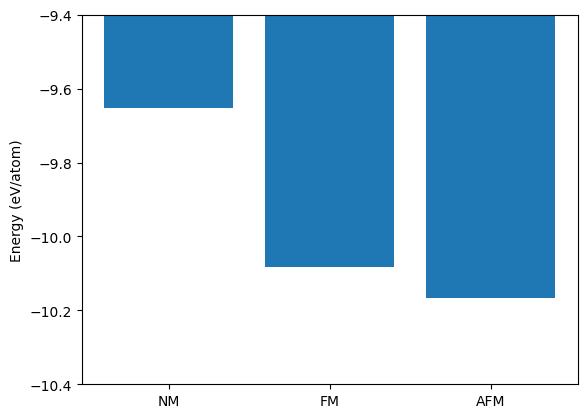

In [24]:
# compare energetic stability
titles = ["NM", "FM", "AFM"]
energies = [nm_outputs.final_energy_per_atom, fm_outputs.final_energy_per_atom, afm_outputs.final_energy_per_atom]
relative_energies = [energy-nm_outputs.final_energy_per_atom for energy in energies]

print("Energies (eV/atom)")
print(f" NM  {nm_outputs.final_energy_per_atom:.3f}")
print(f" FM  {fm_outputs.final_energy_per_atom:.3f}")
print(f" AFM {afm_outputs.final_energy_per_atom:.3f}")

plt.bar(titles, energies)
plt.axhline(0, linestyle="--", color = "black", zorder=0)
plt.ylim(-10.4, -9.4)
plt.ylabel("Energy (eV/atom)")
plt.show()

Note that both the FM and AFM calcualtions are significantly lower in energy than the NM calculation where spin polarization is turned off. As Ni2+ (d8) within an octahedral coordination contains two unpaired electrons, we expect that spin polarization must be accounted for to properly make predictions for rocksalt NiO. 

Notice also that the AFM calculation is lower in energy than the FM calculation. This is in agreement with experimental measurements that rocksalt NiO exhibits an antiferromagnetic ordering below ~525K.
- Usually we want to use the lowest energy calculations for a series of magnetic orderings as DFT is a ground-state theory, however sometimes it can be beneficial to explore other, metastable states as well for certain questions.

In [ ]:
# compare electronic band gap and structures
print("Electronic Band Gap (eV)")
print(f" NM  {nm_outputs.band_gap:.3f}")
print(f" FM  {fm_outputs.band_gap:.3f}")
print(f" AFM {afm_outputs.band_gap:.3f}")

Electronic Band Gap (eV)
 NM  0.000
 FM  0.862
 AFM 2.370


Notice also how including different magnetic orderings within our calculations can *drastically* affect the resulting electronic band gaps. The room temperature NiO electronic band gap is ~3.6-4.0 eV, so we are still quite off from experimental measurements even with the R2SCAN meta-GGA XC functional. However, we can get much closer and obtain *qualitatively* correct band gaps sometimes by carefully exploring these different magnetic states. While this is just a brief example, you can read more about this in some recent papers from Alex Zunger's group.

The corresponding density of states figures can be found in each of the corresponding DOS calculations directories...

## Nonmagnetic
<div>
<img src="./NiO_files/dos_nm/dos.png" width="500"/>
</div>

## Ferromagnetic
<div>
<img src="./NiO_files/dos_fm/dos.png" width="500"/>
</div>

## Antiferromagnetic
<div>
<img src="./NiO_files/dos_afm/dos.png" width="500"/>
</div>